In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np


# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from random import choices

from sklearn.cluster import KMeans

print(tf.executing_eagerly())
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print('GPUs available: {}'.format(physical_devices))

True
2.2.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
data_dir = "data/UCM.tfrecords"

In [3]:
# Define the features in the TFRecords file
features = {
    "image_raw": tf.io.FixedLenSequenceFeature(
        [], dtype=tf.float32, allow_missing=True
    ),
    "height": tf.io.FixedLenFeature([], tf.int64),
    "width": tf.io.FixedLenFeature([], tf.int64),
    "channels": tf.io.FixedLenFeature([], tf.int64),
    "label": tf.io.FixedLenFeature([], tf.int64),
}

In [4]:
def parse_example(example_proto):
    image_features = tf.io.parse_single_example(example_proto, features)
    
    height = tf.cast(image_features["height"], tf.int32)
    width = tf.cast(image_features["width"], tf.int32)
    channels = tf.cast(image_features["channels"], tf.int32)
    
    image_raw = tf.reshape(
        tf.squeeze(image_features["image_raw"]),
        tf.stack([height, width, channels])
    )
    
    target = image_features["label"]
    
    return image_raw, target

In [51]:
def save_file(filename, a):
    with open(filename, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_file(filename)
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
        
    return b

SyntaxError: invalid syntax (<ipython-input-51-e8fba60704c2>, line 5)

## Visualise the data

In [5]:
with open('data/label_dict.pkl', 'rb') as f:
    label_dict = pkl.load(f)

In [6]:
data = tf.data.TFRecordDataset(data_dir).map(parse_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)

data_viz = iter(data.batch(1))

Label: denseresidential
0.518327


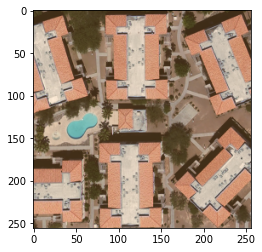

In [7]:
for i in range(50):
    img, label = next(data_viz)
plt.imshow(img.numpy()[0]) #Add 0.5 if it's zero-centered. (it's not quite 0.5 strictly but it's close enough)
print("Label: {}".format(label_dict[label.numpy()[0]]))
print(img.numpy()[0].mean())

## Build the model

Li 2016 - 

Li 2020 - 1e6 patches from 1e5 images

### Build the custom layer in keras

In [8]:
# class CustomKernelInit(tf.keras.initializers.Initializer):
#     def __init__(self, visual_words, w):
#         K = visual_words.shape[0]
#         words_kernel = -2*visual_words.reshape((K, w, w, -1)) # ||x-ck||^2 = x t x - 2ck t x + ck t ck 
#         self.full_kernel = np.append(words_kernel, np.ones(words_kernel.shape), axis=3)
#         self.full_kernel = np.moveaxis(self.full_kernel, 0, -1) #(input rows, input columns, input channels, output channels)
        
#     def __call__(self, shape, dtype=None):
#         return self.full_kernel
def kernel_init(visual_words, w):
        K = visual_words.shape[0]
        words_kernel = -2*visual_words.reshape((K, w, w, -1)) # ||x-ck||^2 = x t x - 2ck t x + ck t ck 
        full_kernel = np.append(words_kernel, np.ones(words_kernel.shape), axis=3)
        full_kernel = np.moveaxis(full_kernel, 0, -1) #(input rows, input columns, input channels, output channels)
        
        return full_kernel

In [9]:
class FeatureMapLayer(tf.keras.layers.Layer):
    def __init__(self, K, w, visual_words):
        super(FeatureMapLayer, self).__init__()
        self.visual_words = visual_words
        self.K = K
        self.w = w
        
        
        
    def build(self, input_shape):
        kernel_initializer = kernel_init(self.visual_words, self.w)
        augmented_shape = (input_shape[0], input_shape[1], input_shape[2], input_shape[3]*2)
        
        self.conv2 = tf.keras.layers.Conv2D(filters=self.K, kernel_size=self.w, use_bias=False,
                                           input_shape=augmented_shape[1:])
        
        self.conv2.build(augmented_shape) 
        self.conv2.set_weights([kernel_init(self.visual_words, self.w)])        

        
    def call(self, input):
        #Augment N image layers w/ N additional layers that are element-wise squared
        input_augmented = tf.concat([input, tf.math.square(input)], axis = 3) 
        #print(input_augmented.shape)
        conv_out = self.conv2(input_augmented) #Returns x t x - 2ck t x
        
        square_word_norms = np.linalg.norm(self.visual_words, axis=1)**2 #Squared norms of the visual words - ck t ck
        
        z2 = conv_out + square_word_norms #Note to self - this might break if K is equal to one of the image dimensions
        z = tf.math.sqrt(z2)
        
        u = tf.math.reduce_mean(z, axis=3) #Take mean over the axis of features (which is of length K)
        u = tf.expand_dims(u, 3)
        u = tf.tile(u, [1,1,1, self.K])
        
        f = tf.math.maximum(0.0, u-z)
        
        return f

Define hyperparameters:

In [10]:
data_numpy = np.stack([x[0] for x in list(data.as_numpy_iterator())]) #Could change this to not load whole dataset into memory if too big
num_images = data_numpy.shape[0]
image_size = data_numpy.shape[1]
no_channels = data_numpy.shape[3]
seed = 0

featureset_size = num_images * 10
no_featurelayers = 2
w = 6 #Size of receptive field for feature mapping
s = 2 #Size of local max pooling window

K = [150, 900]

#### Unsupervised training for first layer (K Means)

In [11]:
%%time
#Unsupervised training for first layer

feature_sets = []
visual_dicts = []

#Randomly sample image patches - for the input layer
image_indices = choices(range(num_images), k = featureset_size)
row_indices = choices(range(image_size - w + 1), k = featureset_size)
col_indices = choices(range(image_size - w + 1), k = featureset_size)

feature_set = []

for i in range(len(image_indices)):
    ii, ri, ci = image_indices[i], row_indices[i], col_indices[i]
    sample_patch = data_numpy[ii][ri:ri+w,ci:ci+w]
    feature_set.append(sample_patch.flatten())
    
feature_set = np.array(feature_set)
feature_sets.append(feature_set)

kmeans = KMeans(n_clusters=K[0], random_state = seed).fit(feature_sets[0])    

visual_dicts.append(kmeans.cluster_centers_)

CPU times: user 11min 1s, sys: 15min 12s, total: 26min 14s
Wall time: 1min 10s


#### Build model for first layer:

In [12]:
inputs = tf.keras.Input(shape=(256,256,3))

feature_map_0 = FeatureMapLayer(K[0], w, np.array(visual_dicts[0]))
f0 = feature_map_0(inputs)

local_pool_0 = tf.keras.layers.MaxPool2D(pool_size=(2,2))
p0 = local_pool_0(f0)

global_pool_size = (p0.shape[1]//2, p0.shape[2]//2)
global_pool_strides = (p0.shape[1]//4, p0.shape[2]//4)
global_pool_0 = tf.keras.layers.AveragePooling2D(pool_size=global_pool_size, strides=global_pool_strides)
g0 = global_pool_0(p0)

flat_0 = tf.keras.layers.Flatten()
out_0 = flat_0(g0)


model_firstlayer = tf.keras.Model(inputs=inputs, outputs=[out_0, p0], name="MultilayerFeatureLearning")

#### Unsupervised training for second layer

In [47]:
%%time
featuremap_0_size = model_firstlayer.predict(data_numpy[0:1])[1].shape[1]

#Randomly sample image patches - for the input layer
image_indices = choices(range(num_images), k = featureset_size)
row_indices = choices(range(featuremap_0_size - w + 1), k = featureset_size)
col_indices = choices(range(featuremap_0_size - w + 1), k = featureset_size)

feature_set = []

for i in range(len(image_indices)):
    ii, ri, ci = image_indices[i], row_indices[i], col_indices[i]
    first_layer_image_out = model_firstlayer.predict(data_numpy[ii:ii+1])
    sample_patch = first_layer_image_out[1][0][ri:ri+w,ci:ci+w]
    feature_set.append(sample_patch.flatten())
    
feature_set = np.array(feature_set)
if len(feature_sets) == 1:
    feature_sets.append(feature_set)
else:
    feature_sets[1] = feature_set

CPU times: user 5min 56s, sys: 7.01 s, total: 6min 3s
Wall time: 5min 53s


In [52]:
%%time
kmeans = KMeans(n_clusters=K[1], random_state = seed, verbose=10).fit(feature_sets[1])    

if len(visual_dicts) == 1:
    visual_dicts.append(kmeans.cluster_centers_)
else:
    visual_dicts[1] = kmeans.cluster_centers_

KeyboardInterrupt: 